In [1]:
import pandas as pd

In [ ]:
def get_raw_accent_map(df):
    accent_counts = df["accents"].value_counts()
    accent_types = accent_counts[0:40].index.tolist()
    accent_map_dict = {
        "accent": accent_types,
        "reduced_accent": [""]*len(accent_types),
    }
    accent_map = pd.DataFrame(accent_map_dict)
    accent_map.to_csv("unprocessed_accent_map.csv", index=False)

In [2]:
accent_map = pd.read_csv("data/accent_map.csv")
validated = pd.read_csv("../raw/validated.tsv", sep="\t")
validated = validated[["client_id", "sentence_id", "path", "sentence", "age", "gender", "accents"]]
print(validated["accents"].value_counts())
validated_reduced = validated[["client_id", "sentence_id", "path", "sentence", "age", "gender"]].copy()
validated_reduced["reduced_accents"] = validated["accents"].map(accent_map.set_index("accent")["reduced_accent"])
print(validated_reduced["reduced_accents"].value_counts())


/var/folders/qn/90h7g4l56pqcr9bp0_c4cfkw0000gn/T/ipykernel_19422/2277223982.py:2: DtypeWarning: Columns (4,12) have mixed types. Specify dtype option on import or set low_memory=False.
  validated = pd.read_csv("../raw/validated.tsv", sep="\t")


accents
United States English                                438469
England English                                      154750
India and South Asia (India, Pakistan, Sri Lanka)    109144
Canadian English                                      75390
Australian English                                    55016
                                                      ...  
Turkmen                                                   1
United States English,British,iowa                        1
Chinese accent of English                                 1
Southern counties English                                 1
South Asia (Bangladesh)                                   1
Name: count, Length: 771, dtype: int64
reduced_accents
North American       523284
British              162814
South Asian          109554
ANZ                   69325
European              53232
South African         26613
Irish                 21127
Scottish              18626
Filipino               6461
SEA                    59

In [3]:
with open("data/available_audio.txt", "r") as f:
    available_audio = pd.Series(f.read().splitlines())
    validated_reduced = validated_reduced[validated_reduced["path"].isin(available_audio)]

In [5]:
def randomise_datapoints(x):
    """Get 300 data points for each accent."""
    if len(x) < 300:
        return x
    else:
        return x.sample(n=300, random_state=42)
# Get 300 data points for each accent
validated_accent_train = validated_reduced.groupby("reduced_accents").apply(randomise_datapoints, include_groups=True).reset_index(drop=True)
validated_accent_train["reduced_accents"].value_counts()

/var/folders/qn/90h7g4l56pqcr9bp0_c4cfkw0000gn/T/ipykernel_19422/3064510566.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validated_accent_train = validated_reduced.groupby("reduced_accents").apply(randomise_datapoints, include_groups=True).reset_index(drop=True)


reduced_accents
ANZ                  300
African              300
British              300
Chinese              300
European             300
Filipino             300
Irish                300
Jamaican             300
North American       300
Northern American    300
SEA                  300
Scottish             300
South African        300
South Asian          300
Name: count, dtype: int64

In [6]:
validated_reduced_subset = validated_reduced[~validated_reduced["path"].isin(validated_accent_train["path"])] 
validated_accent_test = validated_reduced_subset.groupby("reduced_accents").apply(randomise_datapoints, include_groups=True).reset_index(drop=True)
validated_accent_test["reduced_accents"].value_counts()

/var/folders/qn/90h7g4l56pqcr9bp0_c4cfkw0000gn/T/ipykernel_19422/2616287192.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  validated_accent_test = validated_reduced_subset.groupby("reduced_accents").apply(randomise_datapoints, include_groups=True).reset_index(drop=True)


reduced_accents
ANZ                  300
British              300
Chinese              300
European             300
Filipino             300
Irish                300
North American       300
SEA                  300
Scottish             300
South African        300
South Asian          300
Northern American     83
African               43
Name: count, dtype: int64

In [8]:
from pathlib import Path

stem  = Path("data")
audio_data_train_path = stem / "audio_data_train.txt"
audio_data_test_path = stem / "audio_data_test.txt"
accent_train_path = stem / "accent_train.tsv"
accent_test_path = stem / "accent_test.tsv"

audio_data_train = "\n".join(validated_accent_train["path"].tolist())
audio_data_train_path.write_text(audio_data_train)
audio_data_test = "\n".join(validated_accent_test["path"].tolist())
audio_data_test_path.write_text(audio_data_test)
validated_accent_train.to_csv(accent_train_path, index=False, sep="\t")
validated_accent_test.to_csv(accent_test_path, index=False, sep="\t")


In [12]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
from datasets import load_dataset

/Users/quangu/projects/esl-ai/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


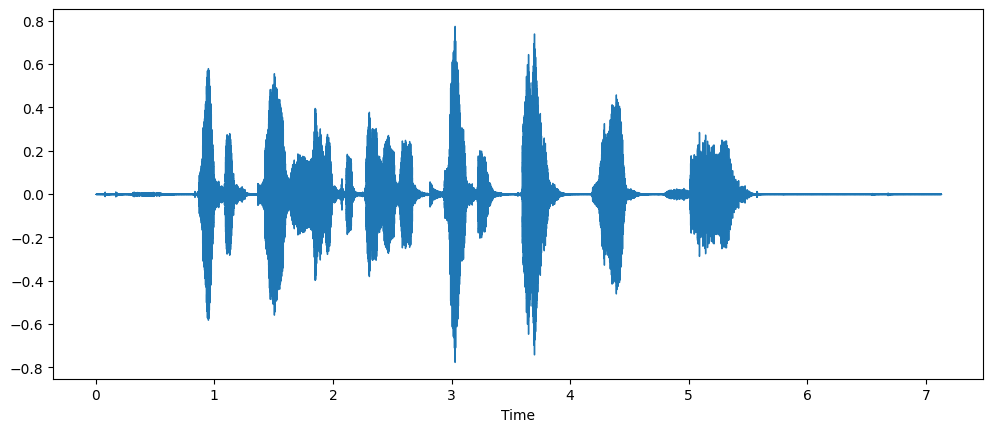

In [20]:
dataset = load_dataset("dataset/")
array = dataset["train"][0]["audio"]["array"]
sampling_rate = dataset["train"][0]["audio"]["sampling_rate"]
plt.figure().set_figwidth(12)
librosa.display.waveshow(array, sr=sampling_rate)

Generating train split: 1 examples [00:00, 422.13 examples/s]


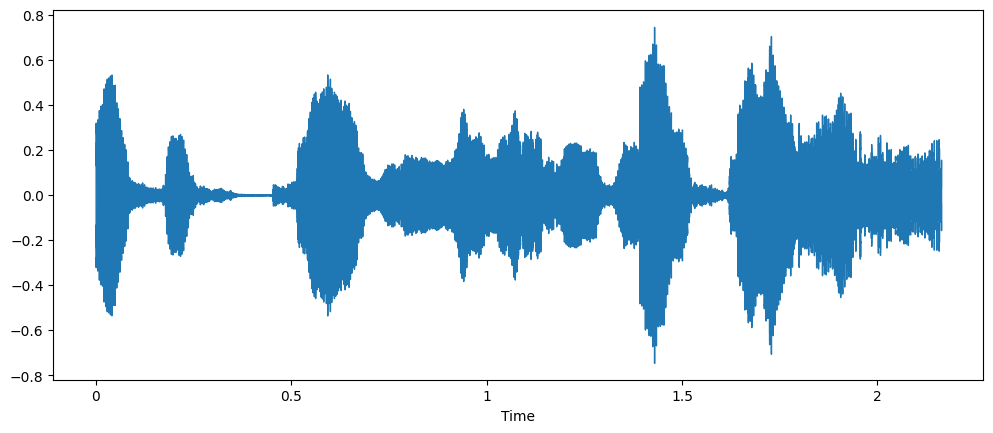

In [27]:
dataset_treated = load_dataset("dataset_treated/")
plt.figure().set_figwidth(12)
librosa.display.waveshow(dataset_treated["train"][0]["audio"]["array"], sr=dataset_treated["train"][0]["audio"]["sampling_rate"])